# SI 630: Homework 1: Classification

Name on Kaggle: ccmilne

In [4]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from collections import Counter
import random

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dev = pd.read_csv('dev.csv')

In [5]:
train['labels'] = np.where(train['party_affiliation'].str.contains("Democratic Party"), 1, 0)
dev['labels'] = np.where(dev['party_affiliation'].str.contains("Democratic Party"), 1, 0)

In [6]:
print(len(train))
print(len(test))
print(len(dev))

59999
20000
20000


In [7]:
test

,email_text,uid_email
0,"20,000 <GPE> <GPE> signatures needed \n 20,000...",5dfbe09ce5b500dd3dcb9f93c8fb185f
1,We 've worked way too hard and given way too m...,07e48f4183b98420a18503791fb412f6
2,If you use your 800%-MATCH \n <> \n <ORG> <OR...,b58c8607d96a414db0e9cc10108c35f5
3,"<PERSON>, a proposal for Vote- by- <> threaten...",3901d9539d69ada89e5c82e2f1ca950d
4,The <ORG> <ORG> <ORG> is under immediate threa...,6a3e8e6f31381e84a34571deee0f1238
...,...,...
19995,View this email in your browser \n View this ...,9b11afd6a84d3806034d9080f4e9752a
19996,There are few things nearly every <NORP> can a...,888cacc2d660bf040f04ef1caf6ce844
19997,FIGHT for the truth by making 1000 % MORE of a...,712dc83f7a455870373c7a9eb30445d7
19998,"I do n't need six- figure checks, but I do nee...",0bf3265244c2c06fff084c5a79a6387c


## Part 1: Text Data

### 1.1: Tokenization

In [8]:
s = 'Before we can start classifying, we need to turn our text data into some numeric representation that classifiers can work with. In class, we talked about using a bag of words representation—i.e., each document is represented as a vector.'

In [10]:
def tokenize(string):
    return string.split()

In [11]:
# tokenize(s)

In [12]:
import re

def better_tokenize(string):
    pattern = r"\w+\w"
    return re.findall(pattern, string.lower())

### Consider removing
# Spacy entity names (e.g. PERSON, NORP)
# Stopwords

# def prune(tokens):
#     spacy = ['person', 'norp', 'org', 'gpe']
#     stopwords = []
#     return None

In [13]:
# better_tokenize(s)

### 1.2: Building the Term-Document Matrix

This section uses four functions to build the term-document matrices for each data set. They include:

- term_frequency()
- build_docs()
- create_vocab()
- create_matrix()

In [14]:
# import sparse module from SciPy package 
from scipy import sparse

In [15]:
def term_frequency(df, minimum_word_frequency=10):
    emails = list(df['email_text'])
    
    #Build Term Frequency Dictionary
    cnt = Counter()
    for email in tqdm(emails):
        tokens = better_tokenize(email)
        for t in tokens:
            cnt[t] += 1

    #Remove rare words
    minimum_word_frequency = 10
    only_common = Counter({k: v for k, v in cnt.items() if v >= minimum_word_frequency})
    
    return only_common

In [16]:
def build_docs(df, term_freq):
    emails = list(df['email_text'])
    
    docs = {}
    counter = 1
    
    for email in tqdm(emails):
        tokens = better_tokenize(email)    
        for t in tokens:
            if t not in term_freq.keys(): tokens.remove(t)
        docs[counter] = tokens
        counter += 1

    return docs

In [17]:
def create_vocab(docs):
    n_nonzero = 0 #number of nonzero values in the matrix
    vocab = set()

    for docterms in docs.values():
        unique_terms = set(docterms)    # all unique terms of this doc
        vocab |= unique_terms           # set union: add unique terms of this doc
        n_nonzero += len(unique_terms)  # add count of unique terms in this doc

    docnames = np.array(list(docs.keys()))
    vocab = np.array(list(vocab))
    vocab_sorter = np.argsort(vocab)

    ndocs = len(docnames) #Matrix rows
    nvocab = len(vocab) #Matrix columns

    data = np.empty(n_nonzero, dtype=np.intc)
    rows = np.empty(n_nonzero, dtype=np.intc)
    cols = np.empty(n_nonzero, dtype=np.intc)
    
    print(n_nonzero)
    
    return vocab, vocab_sorter, data, rows, cols, ndocs, nvocab

In [18]:
def create_matrix(docs, vocab, vocab_sorter, data, rows, cols, ndocs, nvocab):
    current_index = 0
    
    docnames = np.arange(1, len(docs) + 1)

    for docname, terms in tqdm(docs.items()):
#         term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]
        try:
            term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]
        except:
            print("Error with doc:")
            print(docname)
            print(len(terms))
            print(terms)
            
        uniq_indices, counts = np.unique(term_indices, return_counts=True)
        n_vals = len(uniq_indices)
        ind_end = current_index + n_vals

        data[current_index:ind_end] = counts
        cols[current_index:ind_end] = uniq_indices
        doc_idx = np.where(docnames == docname)
        rows[current_index:ind_end] = np.repeat(doc_idx, n_vals)

        current_index = ind_end
        
#     print(ndocs)
#     print(nvocab)
    
#     print(len(data))
#     print(len(rows))
#     print(len(cols))
    
    sparse_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(ndocs, nvocab), dtype=np.intc)
    return sparse_matrix

Training Data

In [19]:
term_freq_train = term_frequency(df=train)
docs_train = build_docs(train, term_freq_train)

vocab, vocab_sorter, data, rows, cols, ndocs, nvocab = create_vocab(docs_train)

sparse_matrix_train = create_matrix(docs_train, vocab, vocab_sorter, data, rows, cols, ndocs, nvocab)

100%|██████████| 59999/59999 [00:15<00:00, 3765.39it/s]


9891710


100%|██████████| 59999/59999 [00:21<00:00, 2764.68it/s]


In [20]:
sparse_matrix_train

<59999x15389 sparse matrix of type '<class 'numpy.int32'>'
	with 9891710 stored elements in Compressed Sparse Row format>

Development/Validation Data

In [21]:
term_freq_dev = term_frequency(df=dev)
docs_dev = build_docs(dev, term_freq_dev)

vocab_dev, vocab_sorter_dev, data_dev, rows_dev, cols_dev, ndocs_dev, nvocab_dev = create_vocab(docs_dev)

100%|██████████| 20000/20000 [00:05<00:00, 3432.40it/s]


3276049


In [22]:
ndocs_dev = len(docs_dev)

sparse_matrix_dev = create_matrix(docs_dev, vocab, vocab_sorter, data_dev, rows_dev, cols_dev, ndocs_dev, nvocab)

100%|██████████| 20000/20000 [00:06<00:00, 3187.27it/s]


In [23]:
sparse_matrix_dev

<20000x15389 sparse matrix of type '<class 'numpy.int32'>'
	with 3276016 stored elements in Compressed Sparse Row format>

Testing Data

In [24]:
term_freq_test = term_frequency(df=test)
docs_test = build_docs(test, term_freq_test)

vocab_test, vocab_sorter_test, data_test, rows_test, cols_test, ndocs_test, nvocab_test = create_vocab(docs_test)

100%|██████████| 20000/20000 [00:05<00:00, 3685.84it/s]


3271543


In [26]:
ndocs_test = len(docs_test)

sparse_matrix_test = create_matrix(docs_test, vocab, vocab_sorter, data_test, rows_test, cols_test, ndocs_test, nvocab)

 59%|█████▊    | 11709/20000 [00:03<00:02, 3116.49it/s]

Error with doc:
11108
454
['person', 'is', 'going', 'to', 'be', 'the', 'top', 'target', 'of', 'the', 'as', 'the', 'org', 'prepares', 'to', 'confirm', 'person', 'nominee', 'person', 'person', 'needs', 'to', 'know', 'you', 're', 'with', 'him', 'his', 'liberal', 'opponent', 'has', 'raised', 'more', 'in', 'three', 'months', 'than', 'most', 'other', 'races', 'have', 'raised', 'in', 'an', 'entire', 'year', 'the', 'amount', 'of', 'money', 'the', 'is', 'raising', 'and', 'spending', 'to', 'defeat', 'person', 'person', 'is', 'unprecedented', 'and', 'person', 'it', 'only', 'going', 'to', 'get', 'worse', 'this', 'week', 'as', 'chairman', 'of', 'the', 'org', 'org', 'org', 'person', 'is', 'going', 'to', 'be', 'the', 'top', 'target', 'of', 'the', 'as', 'the', 'org', 'prepares', 'to', 'confirm', 'person', 'nominee', 'person', 'person', 'person', 'the', 'has', 'millions', 'at', 'their', 'disposal', 'to', 'attack', 'person', 'person', 'but', 'we', 're', 'only', 'asking', 'for', 'or', '10', 'to', 'show',

100%|██████████| 20000/20000 [00:06<00:00, 3189.68it/s]


In [27]:
sparse_matrix_test

<20000x15389 sparse matrix of type '<class 'numpy.int32'>'
	with 3271395 stored elements in Compressed Sparse Row format>

## Part 2: Logistic Regression in numpy

In [28]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

In [29]:
def log_likelihood(b, X, y):
    '''
    Calculates the log likelihood (aka maximum likelihood) 
    of the training data given Beta parameters    
    '''
    return np.dot(y, X*b) - np.log(1 + np.exp(X*b)).sum()

In [30]:
def compute_gradient(b, X, y):
    return X * (sigmoid(np.dot(b, X)) - y)

In [31]:
def logistic_regression(X, y, learning_rate, num_steps):
    '''
    Logistic regression function that takes in:
    
    – a matrix X where each row is a vector that has the features for that instance
    – a vector Y containing the class of the row
    – learning rate which is a parameter to control how much you change the β values each step
    – num step how many steps to update β before stopping
    
    '''
    ### Initialize parameters (betas)
#     betas = (np.random.random(X.shape[1]) - 0.5) / 100
    betas = np.zeros(X.shape[1])    
    
    lls = []
    
    idx = 0
    
    for i in range(num_steps):
        betas -= learning_rate * compute_gradient(b=betas, X=X[idx].toarray()[0], y=y[idx])
        
        ### Compute log likelihood to observe the loss rate (for graphing purposes)
        if i % 100 == 100 - 1: #any time the remainder of i-100=99: 
            ll = log_likelihood(b=betas, X=X, y=y)
            lls.append(ll)
            print(f"Turn {i + 1}: ll: {ll}")
        
#         idx += 1
        idx = (idx + 1) % X.shape[0]
    
    return (betas, lls)

Training Data and Log-Likelihood Mapping

In [32]:
X = sparse_matrix_train
y = list(train['labels'])

model = logistic_regression(X, y, learning_rate=1e-5, num_steps=1000)

Turn 100: ll: -35703.508718314646
Turn 200: ll: -33736.60604505231
Turn 300: ll: -32211.096881655365
Turn 400: ll: -31455.449747412582
Turn 500: ll: -30979.55760565806
Turn 600: ll: -30625.516861198033
Turn 700: ll: -30138.87604433771
Turn 800: ll: -29988.44506420396
Turn 900: ll: -29936.20330069991
Turn 1000: ll: -29839.31606744809


In [33]:
betas = model[0]
betas

array([0.00000000e+00, 8.70712706e-06, 9.94368107e-05, ...,
       9.78785038e-06, 6.89300641e-06, 0.00000000e+00])

In [34]:
lls = model[1]

ValueError: ignored

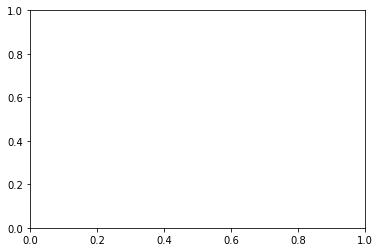

In [35]:
import matplotlib.pyplot as plt

lls = model[1]

x_axis = np.arange(0, 60000, 100)

plt.figure()
plt.plot(x_axis, lls)
plt.title("Convergence Graph of Log-Likelihood")
plt.xlim(-50, 60000)
plt.xlabel("Number of Iterations")
plt.ylabel("Log-Likelihood")
plt.show()

In [36]:
def predict(b, X, y, threshold=0.5):
    '''   
    Prediction function that takes in:
    
    - betas from training set
    - a vector X from a dev/test set
    - a vector y as the true values
    '''
    iterations = len(y) #X.shape[0]
    
    y_predictions = 0
    idx = 0
    
    for i in tqdm(range(iterations)):
        outcome = np.round(sigmoid(np.dot(X[idx].toarray()[0], b)))
        if outcome == y[idx]:
            y_predictions += 1
        idx += 1
        
#     outcome = np.round(sigmoid(np.dot(X, b))) >= threshold
#     return outcome
    return y_predictions

In [37]:
X = sparse_matrix_dev
y_dev = list(dev['labels'])

In [38]:
y_predictions = predict(betas, X, y_dev)

100%|██████████| 20000/20000 [00:04<00:00, 4012.55it/s]


In [39]:
f1 = y_predictions / len(y_dev)
f1

0.8047

Submission for Kaggle with test data

In [ ]:
X = sparse_matrix_train
y = list(train['labels'])

model = logistic_regression(X, y, learning_rate=1e-5, num_steps=100000)
betas = model[0]

Turn 100: ll: -35703.50871831464
Turn 200: ll: -33736.60604505231
Turn 300: ll: -32211.09688165535
Turn 400: ll: -31455.44974741259
Turn 500: ll: -30979.55760565806
Turn 600: ll: -30625.516861198033
Turn 700: ll: -30138.87604433771
Turn 800: ll: -29988.445064203952
Turn 900: ll: -29936.203300699948
Turn 1000: ll: -29839.31606744811
Turn 1100: ll: -29830.96242771791
Turn 1200: ll: -29763.28978384393
Turn 1300: ll: -29773.295873981275
Turn 1400: ll: -29667.93175517941
Turn 1500: ll: -29529.64976326433
Turn 1600: ll: -29472.68770463542
Turn 1700: ll: -29410.726309523423
Turn 1800: ll: -29376.257012897593
Turn 1900: ll: -29291.25626646432
Turn 2000: ll: -29237.17441419323
Turn 2100: ll: -29166.58580461472
Turn 2200: ll: -29112.061106729932
Turn 2300: ll: -29079.39206569115
Turn 2400: ll: -29003.323058343318
Turn 2500: ll: -28960.14702938219
Turn 2600: ll: -28950.72671527654
Turn 2700: ll: -28894.481492140083
Turn 2800: ll: -28792.246458935755
Turn 2900: ll: -28727.82341159611
Turn 3000: ll

Turn 23500: ll: -23498.746907850786
Turn 23600: ll: -23472.013133286877
Turn 23700: ll: -23503.86467241551
Turn 23800: ll: -23473.1446742705
Turn 23900: ll: -23442.780304427477
Turn 24000: ll: -23434.8933969855
Turn 24100: ll: -23427.55260080524
Turn 24200: ll: -23436.17163569873
Turn 24300: ll: -23399.61559365633
Turn 24400: ll: -23373.573166874397
Turn 24500: ll: -23358.785124498783
Turn 24600: ll: -23347.58513329942
Turn 24700: ll: -23332.876400324007
Turn 24800: ll: -23321.99630329627
Turn 24900: ll: -23310.468042362583
Turn 25000: ll: -23299.119651651214
Turn 25100: ll: -23302.420552639596
Turn 25200: ll: -23283.001246892018
Turn 25300: ll: -23291.297354036054
Turn 25400: ll: -23353.204937586095
Turn 25500: ll: -23306.62614293446
Turn 25600: ll: -23390.42119565177
Turn 25700: ll: -23246.047306090142
Turn 25800: ll: -23319.224289312988
Turn 25900: ll: -23205.009034970863
Turn 26000: ll: -23162.311451264657
Turn 26100: ll: -23154.56931337365
Turn 26200: ll: -23146.22318727817
Turn 2

Turn 46600: ll: -21315.073244633357
Turn 46700: ll: -21300.65622827444
Turn 46800: ll: -21350.52847840739
Turn 46900: ll: -21385.956267503032
Turn 47000: ll: -21318.287733413046
Turn 47100: ll: -21316.294417718163
Turn 47200: ll: -21280.754633465214
Turn 47300: ll: -21335.519982622995
Turn 47400: ll: -21425.3727700546
Turn 47500: ll: -21411.007619574535
Turn 47600: ll: -21418.282930113608
Turn 47700: ll: -21432.140895645687
Turn 47800: ll: -21359.03419734897
Turn 47900: ll: -21329.85079719455
Turn 48000: ll: -21264.275889988116
Turn 48100: ll: -21218.502027901777
Turn 48200: ll: -21143.476283614335
Turn 48300: ll: -21135.807328996234
Turn 48400: ll: -21167.854257219704
Turn 48500: ll: -21222.101506665553
Turn 48600: ll: -21209.450249806134
Turn 48700: ll: -21167.677077140164
Turn 48800: ll: -21151.6523523504
Turn 48900: ll: -21130.593940551043
Turn 49000: ll: -21115.570640493286
Turn 49100: ll: -21075.37638831389
Turn 49200: ll: -21067.307128069588
Turn 49300: ll: -21058.176097691336
T

Turn 69600: ll: -19774.291906812563
Turn 69700: ll: -19792.851310360245
Turn 69800: ll: -19766.506837956287
Turn 69900: ll: -19790.537843318714
Turn 70000: ll: -19783.655179621797
Turn 70100: ll: -19756.517666863045
Turn 70200: ll: -19748.831252124146
Turn 70300: ll: -19752.152942185916
Turn 70400: ll: -19728.866952336786
Turn 70500: ll: -19755.355721130938
Turn 70600: ll: -19735.51754110925
Turn 70700: ll: -19733.749690727564
Turn 70800: ll: -19821.01278714917
Turn 70900: ll: -19838.83774469758
Turn 71000: ll: -19743.58485325014
Turn 71100: ll: -19732.894905009365
Turn 71200: ll: -19754.131812619744
Turn 71300: ll: -19711.306608165716
Turn 71400: ll: -19674.444014858134
Turn 71500: ll: -19670.248792262122
Turn 71600: ll: -19675.29503815208
Turn 71700: ll: -19661.40898753979
Turn 71800: ll: -19659.228775914045
Turn 71900: ll: -19690.98141428767
Turn 72000: ll: -19691.038228898033
Turn 72100: ll: -19682.95941404211
Turn 72200: ll: -19661.694247532316
Turn 72300: ll: -19638.321040629366


Turn 92600: ll: -18679.278805668087
Turn 92700: ll: -18674.795728489233
Turn 92800: ll: -18670.82922500586
Turn 92900: ll: -18668.367709324943
Turn 93000: ll: -18661.942970873497
Turn 93100: ll: -18657.49254547697
Turn 93200: ll: -18661.737941422543
Turn 93300: ll: -18659.52372310146
Turn 93400: ll: -18659.891978676227
Turn 93500: ll: -18647.299443696917
Turn 93600: ll: -18635.13060700074
Turn 93700: ll: -18628.832235397145
Turn 93800: ll: -18626.378485230176
Turn 93900: ll: -18621.420083613833
Turn 94000: ll: -18619.469818698082
Turn 94100: ll: -18620.15167064243
Turn 94200: ll: -18644.652718786267
Turn 94300: ll: -18660.772632320368
Turn 94400: ll: -18609.248518898617
Turn 94500: ll: -18599.26938454341
Turn 94600: ll: -18593.68967366955
Turn 94700: ll: -18596.817887031022
Turn 94800: ll: -18621.1828065757
Turn 94900: ll: -18625.002759883006
Turn 95000: ll: -18620.06172298506
Turn 95100: ll: -18588.27789247832
Turn 95200: ll: -18597.729696576906
Turn 95300: ll: -18570.150600688416
Tur

In [40]:
def predict(b, X, threshold=0.5):
    
    outcomes = []
    idx = 0
    
    for i in tqdm(range(sparse_matrix_test.shape[0])):
        outcome = sigmoid(np.dot(X[idx].toarray()[0], b))
#         print(outcome)

        if outcome > threshold:
            outcomes.append("Democratic Party")
        else:
            outcomes.append("Republican Party")         
        idx += 1
        
    return outcomes

In [41]:
predictions = predict(betas, sparse_matrix_test)

100%|██████████| 20000/20000 [00:04<00:00, 4581.46it/s]


In [43]:
np.unique(predictions, return_counts=True)

(array(['Democratic Party', 'Republican Party'], dtype='<U16'),
 array([19999,     1]))

In [44]:
test['party_affiliation'] = predictions
submission_df = test[['uid_email', 'party_affiliation']]
submission_df

,uid_email,party_affiliation
0,5dfbe09ce5b500dd3dcb9f93c8fb185f,Democratic Party
1,07e48f4183b98420a18503791fb412f6,Democratic Party
2,b58c8607d96a414db0e9cc10108c35f5,Democratic Party
3,3901d9539d69ada89e5c82e2f1ca950d,Democratic Party
4,6a3e8e6f31381e84a34571deee0f1238,Democratic Party
...,...,...
19995,9b11afd6a84d3806034d9080f4e9752a,Democratic Party
19996,888cacc2d660bf040f04ef1caf6ce844,Democratic Party
19997,712dc83f7a455870373c7a9eb30445d7,Democratic Party
19998,0bf3265244c2c06fff084c5a79a6387c,Democratic Party


In [ ]:
submission_df.to_csv('numpy_logit_submission.csv', index=False)

## Part 3: Logistic Regression with PyTorch

In [55]:
import torch

In [92]:
def to_sparse_tensor(sparse_matrix):
    X = sparse_matrix.tocoo()
    # return torch.sparse.LongTensor(torch.LongTensor([coo.row.tolist(), coo.col.tolist(),]), torch.LongTensor(coo.data.astype(np.long)))
    return torch.sparse_coo_tensor(np.mat([X.row, X.col]), X.data, size = X.shape).to(torch.float)

sparse_tensor_train = to_sparse_tensor(sparse_matrix_train)
sparse_tensor_dev = to_sparse_tensor(sparse_matrix_dev)
sparse_tensor_test = to_sparse_tensor(sparse_matrix_test)

In [102]:
sparse_tensor_train.to(torch.float)

tensor(indices=tensor([[    0,     0,     0,  ..., 59998, 59998, 59998],
                       [  100,   129,   157,  ..., 15136, 15253, 15356]]),
       values=tensor([2., 1., 2.,  ..., 1., 3., 1.]),
       size=(59999, 15389), nnz=9891710, layout=torch.sparse_coo)

In [94]:
y_train = torch.tensor(list(train['labels']), dtype=torch.float)

In [103]:
y_train

tensor([1., 1., 1.,  ..., 0., 1., 1.])

In [104]:
import torch.nn as nn
import torch.nn.functional as F

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim): #input_dim, output_dim
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim) #input_dim, output_dim
        
    def forward(self, x):
        outputs = F.sigmoid(self.linear(x))
        return outputs

input_dim = sparse_tensor_train.shape[1] #size of vocabulary
output_dim = 1 #output should always be zero or one
    
model = LogisticRegression(input_dim, output_dim)

In [97]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [108]:
idx = 0

for step in range(1000):
    
#     model.train()
    optimizer.zero_grad()
    
    #forward pass
    predictions = model(sparse_tensor_train).squeeze()
    
    print(predictions.shape)

    #compute loss
    loss = criterion(predictions, y_train)
    
    #backward pass
    loss.backward()
    optimizer.step()
    
    idx += 1
    
    if idx % 100 == 99:
        
        #Report Loss
        print(f"Turn {i + 1}: ll: {ll}")
        
        #Evaluate on Dev Data
        pass

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([59999])
torch.Size([59999])
torch.Size([59999])
torch.Size([59999])
torch.Size([59999])
torch.Size([59999])
torch.Size([59999])


KeyboardInterrupt: ignored

In [ ]:
indices = np.arange(10)

for epoch in range(1000):
    running_loss = 0.0
    
    #Random Sampling
    np.random.shuffle(indices)
    
    for sample in range(len(indices)):
        i = indices[sample]
        
        X = sparse_matrix_train[i]
        target = train_y[i]
        
        
    